# Time diagrams

## Imports

In [1]:
{-# LANGUAGE NoMonomorphismRestriction #-}
{-# LANGUAGE FlexibleContexts          #-}
{-# LANGUAGE TypeFamilies              #-}

import System.Random
import Diagrams.Prelude
import Diagrams.Backend.Cairo
import Data.Colour

## Bespoke constants

In [2]:
myRed :: Colour Double
myRed = sRGB24 214 39 40

myBlue :: Colour Double
myBlue = sRGB24 31 119 180

myGreen :: Colour Double
myGreen = sRGB24 44 160 44

_WORLDLENGTH :: Double
_WORLDLENGTH = 350

## Making timeline diagrams

### Process lines

In [3]:
mkProcLabel :: String -> Diagram B
mkProcLabel lbl = 
  (text lbl # fontSizeL 5 # fc black <>
  rect 30 20 # lw 0 # lw 0) # translateX (-15)

-- Make a process timeline, a simple _WORLDLENGTH-length line with a label on the left
mkProcessLine :: String -> Diagram B
mkProcessLine name = 
  mkProcLabel name ||| arrowBetween' arrowStyle start end # lineOpts
  where
    start = p2 (0, 0)
    end   = p2 (_WORLDLENGTH , 0)
    arrowStyle = with & arrowHead .~ tri & headLength .~ small
    lineOpts = lwL 1 . lc black

### Operational Boxes

In [8]:
-- Create an label on an event
mkOperationLabel :: String
                 -> Diagram B
mkOperationLabel label = 
  circle 0.1 # lw 0 <>
  text label # fontSizeL 5 # translateY 5

mkOperation :: String -- ^ Name
            -> String -- ^ Label
            -> Double -- ^ Start time
            -> Double -- ^ Duration
            -> Diagram B
mkOperation name labelstr start duration =
  (label === operation) # translate offset
  where
    label = mkEventLabel labelstr
    offset = xoff ^& yoff
    yoff = 3.4
    xoff = start + (duration/2)
    box = rect duration 3 # lw 2
    operation = s <> t <> box # fc myBlue
    s = mempty # named (name .> "start") # translateX (-duration/2)
    t = mempty # named (name .> "stop") # translateX (duration/2)

### Events

In [11]:
mkEventLabel :: String -> Diagram B
mkEventLabel lbl = 
  text lbl # fontSizeL 5 # fc black
  <>
  rect 20 10 # lw 0 # fc white
  
mkEvent :: String -- ^ Name
        -> String -- ^ Label
        -> Double -- ^ Start time
        -> Maybe (Double, Double) -- ^ Label offset
        -> Diagram B -- ^ Marker
        -> Diagram B
mkEvent name labelstr start mlbloff marker =
  (marker <> label) # named name # translateX start
  where
    label = mkEventLabel labelstr # offset_label 
    offset_label = maybe id (\offset -> translate (r2 offset)) mlbloff

Line 17: Avoid lambda
Found:
\ offset -> translate (r2 offset)
Why not:
translate . r2

### Misc

In [20]:
eventCircle :: Diagram B
eventCircle  = circle 3 # fc black # lw 0

--noCircle :: String -> Diagram B
--noCircle lbl = mkPointLabel lbl # translateY (-10)

--linearizationPoint :: String -> Diagram B
--linearizationPoint _ =
--  rect 5 20 # fc red # lw 0 # translateY 1.5

attach' :: (IsName n1, IsName n2) => ArrowOpts Double -> (n1, n2) -> Diagram B -> Diagram B
attach' opts (n1, n2) = 
  withName n1 $ \b1 ->
  withName n2 $ \b2 ->
       beneath (arrowBetween' opts (location b1) (location b2))

-- (arrow options, pairs of names (from, to) to draw, the diagram w/o arrows)
attachAll' :: (IsName n1, IsName n2) => ArrowOpts Double -> [(n1, n2)] -> Diagram B -> Diagram B
attachAll' opts = appEndo . foldMap (Endo . attach' opts)

-- (arrow options, pairs of names (from, to) to draw, the diagram w/o arrows)
attachAllOutside' :: (IsName n1, IsName n2) => ArrowOpts Double -> [(n1, n2)] -> Diagram B -> Diagram B
attachAllOutside' opts = appEndo . foldMap (Endo . uncurry (connectOutside' opts))

### Making entire worlds

In [21]:
mkWorldLine :: String  -- ^ Left-most label
            -> Double  -- ^ Y (vertical) coordinate of worldline
            -> [(String, String, Double, Double)] -- ^ Operations (name of operation, label, start point, duration)
            -> [(String, String, Double, Maybe (Double, Double), Diagram B)] -- ^ Events (name of event, label, start point, maybe (x,y) offset for label, rendering function)
            -> Diagram B
mkWorldLine name y ops evs = 
  (mconcat events <>
   mkProcessLine name <> 
   mconcat operations) # translateY y 
                       # (.>>) name
  where
    operations = (\(nm,lbl,s,dur) -> mkOperation nm lbl s dur) <$> ops
    events     = (\(nm,lbl,s,mlbloff,marker) -> mkEvent nm lbl s mlbloff marker) <$> evs

mkWorlds :: (IsName n1, IsName n2)
         => [(String, Double, [(String, String, Double, Double)], [(String, String, Double, Maybe (Double, Double), Diagram B)])]
         -> [(n1, n2)]
         -> ArrowOpts Double
         -> Diagram B
mkWorlds worlds arrowPoints opts = 
    attachAll opts arrowPoints ws
  where
  ws = foldMap (\(name, y, ops, evs) -> mkWorldLine name y ops evs) worlds

# Message Passing

We set some options up for arrows in this section

In [22]:
messagePassingArrowOpts :: ArrowOpts Double
messagePassingArrowOpts = with & arrowHead  .~ dart 
       & arrowTail .~ noTail
       & headLength .~ normal
       & tailLength .~ normal
       & headGap    .~ small
       & shaftStyle %~ lwL 1

In [43]:
send :: String -> String
send str = str ++ "^\\textrm{send}"

recv :: String -> String
recv str = str ++ "^\\textrm{recv}"

math :: String -> String
math str = "$" ++ str ++ "$"

littleup = littleup
littledown = littledown

## Example 1

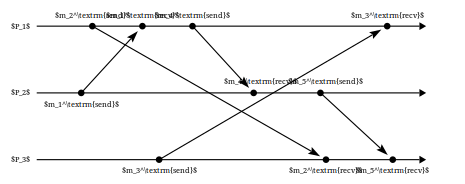

In [45]:
messagePassingExample :: Diagram B
messagePassingExample = pad 1.1 $
     mkWorlds [ ("$P_1$", 70,  [], [m2send, m1recv, m4send, m3recv])
              , ("$P_2$", 10,  [], [m1send, m4recv, m5send])
              , ("$P_3$", -50, [], [m3send, m2recv, m5recv])
              ]
              [ ("m1s", "m1r")
              , ("m4s", "m4r")
              , ("m3s", "m3r")
              , ("m5s", "m5r")
              , ("m2s", "m2r")
              ]
              messagePassingArrowOpts
  where
    m2send = ("m2s", math $ send "m_2", 50, littleup, eventCircle)
    m1recv = ("m1r", math $ recv "m_1", 95, littleup, eventCircle)
    m4send = ("m4s", math $ send "m_4", 140, littleup, eventCircle)
    m3recv = ("m3r", math $ recv "m_3", 315, littleup, eventCircle)
    m1send = ("m1s", math $ send "m_1", 40, littledown, eventCircle)
    m5send = ("m5s", math $ send "m_5", 255, Just (5, 10), eventCircle)
    m4recv = ("m4r", math $ recv "m_4", 195, Just (6, 10), eventCircle)
    m3send = ("m3s", math $ send "m_3", 110, littledown, eventCircle)
    m5recv = ("m5r", math $ recv "m_5", 320, littledown, eventCircle)
    m2recv = ("m2r", math $ recv "m_2", 260, littledown, eventCircle)


diagram messagePassingExample

### Example 1 with Scalar Clocks

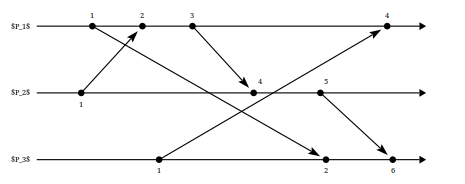

In [46]:
messagePassingExampleScalar :: Diagram B
messagePassingExampleScalar = pad 1.1 $
     mkWorlds [ ("$P_1$", 70,  [], [m2send, m1recv, m4send, m3recv])
              , ("$P_2$", 10,  [], [m1send, m4recv, m5send])
              , ("$P_3$", -50, [], [m3send, m2recv, m5recv])
              ]
              [ ("m1s", "m1r")
              , ("m4s", "m4r")
              , ("m3s", "m3r")
              , ("m5s", "m5r")
              , ("m2s", "m2r")
              ]
              messagePassingArrowOpts
  where
    m2send = ("m2s", "1", 50, littleup, eventCircle)
    m1recv = ("m1r", "2", 95, littleup, eventCircle)
    m4send = ("m4s", "3", 140, littleup, eventCircle)
    m3recv = ("m3r", "4", 315, littleup, eventCircle)
    m1send = ("m1s", "1", 40, littledown, eventCircle)
    m4recv = ("m4r", "4", 195, Just (6, 10), eventCircle)
    m5send = ("m5s", "5", 255, Just (5, 10), eventCircle)
    m3send = ("m3s", "1", 110, littledown, eventCircle)
    m2recv = ("m2r", "2", 260, littledown, eventCircle)
    m5recv = ("m5r", "6", 320, littledown, eventCircle)


diagram messagePassingExampleScalar

## Example 2

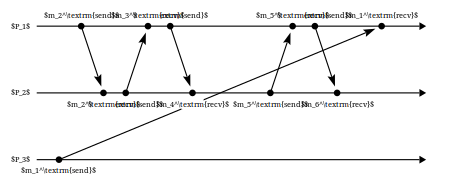

In [49]:
messagePassingExample2 :: Diagram B
messagePassingExample2 = pad 1.1 $
     mkWorlds [ ("$P_1$", 70, [], [ m2send, m3recv, m4send, m5recv, m6send, m1recv ])
              , ("$P_2$", 10, [], [ m2recv, m3send, m4recv, m5send, m6recv ])
              , ("$P_3$", -50, [], [ m1send ])
              ]
              [ ("m1send", "m1recv")
              , ("m2send", "m2recv")
              , ("m3send", "m3recv")
              , ("m4send", "m4recv")
              , ("m5send", "m5recv")
              , ("m6send", "m6recv")
              ]
              messagePassingArrowOpts
  where
    m1send = ("m1send", "$m_1^\\textrm{send}$", 20, littledown, eventCircle)
    m1recv = ("m1recv", "$m_1^\\textrm{recv}$", 310, littleup, eventCircle)
    m2send = ("m2send", "$m_2^\\textrm{send}$", 40, littleup, eventCircle)
    m2recv = ("m2recv", "$m_2^\\textrm{recv}$", 60, littledown, eventCircle)
    m3send = ("m3send", "$m_3^\\textrm{send}$", 80, littledown, eventCircle)
    m3recv = ("m3recv", "$m_3^\\textrm{recv}$", 100, littleup, eventCircle)
    m4send = ("m4send", "$m_4^\\textrm{send}$", 120, littleup, eventCircle)
    m4recv = ("m4recv", "$m_4^\\textrm{recv}$", 140, littledown, eventCircle)
    m5send = ("m5send", "$m_5^\\textrm{send}$", 210, littledown, eventCircle)
    m5recv = ("m5recv", "$m_5^\\textrm{recv}$", 230, littleup, eventCircle)
    m6send = ("m6send", "$m_6^\\textrm{send}$", 250, littleup, eventCircle)
    m6recv = ("m6recv", "$m_6^\\textrm{recv}$", 270, littledown, eventCircle)

    
diagram messagePassingExample2

### Example 2 with Scalar Clocks

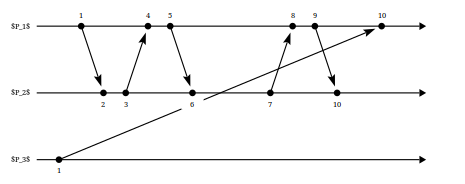

In [51]:
messagePassingExampleScalar2 :: Diagram B
messagePassingExampleScalar2 = pad 1.1 $
     mkWorlds [ ("$P_1$", 70, [], [ m2send, m3recv, m4send, m5recv, m6send, m1recv ])
              , ("$P_2$", 10, [], [ m2recv, m3send, m4recv, m5send, m6recv ])
              , ("$P_3$", -50, [], [ m1send ])
              ]
              [ ("m1send", "m1recv")
              , ("m2send", "m2recv")
              , ("m3send", "m3recv")
              , ("m4send", "m4recv")
              , ("m5send", "m5recv")
              , ("m6send", "m6recv")
              ]
              messagePassingArrowOpts
  where
    m1send = ("m1send", "1", 20, littledown, eventCircle)
    m1recv = ("m1recv", "10", 310, littleup, eventCircle)
    m2send = ("m2send", "1", 40, littleup, eventCircle)
    m2recv = ("m2recv", "2", 60, littledown, eventCircle)
    m3send = ("m3send", "3", 80, littledown, eventCircle)
    m3recv = ("m3recv", "4", 100, littleup, eventCircle)
    m4send = ("m4send", "5", 120, littleup, eventCircle)
    m4recv = ("m4recv", "6", 140, littledown, eventCircle)
    m5send = ("m5send", "7", 210, littledown, eventCircle)
    m5recv = ("m5recv", "8", 230, littleup, eventCircle)
    m6send = ("m6send", "9", 250, littleup, eventCircle)
    m6recv = ("m6recv", "10", 270, littledown, eventCircle)
    
diagram messagePassingExampleScalar2

## Example 3

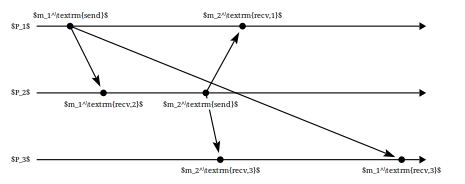

In [66]:
messagePassingExample3 :: Diagram B
messagePassingExample3 = pad 1.1 $
     mkWorlds [ ("$P_1$", 70, [], [ m1send, m2recv1])
              , ("$P_2$", 10, [], [ m1recv2, m2send])
              , ("$P_3$", -50, [], [ m2recv3, m1recv3 ])
              ]
              [ ("m1send", "m1recv1")
              , ("m1send", "m1recv2")
              , ("m1send", "m1recv3")
              , ("m2send", "m2recv1")
              , ("m2send", "m2recv3")
              ]
              messagePassingArrowOpts
  where
    m1send  = ("m1send", math $ send "m_1", 30, littleup, eventCircle)
    m1recv3 = ("m1recv3", math "m_1^\\textrm{recv,3}", 328, littledown, eventCircle)
    m1recv2 = ("m1recv2", "$m_1^\\textrm{recv,2}$", 60, littledown, eventCircle)
    m2send  = ("m2send", "$m_2^\\textrm{send}$", 152, Just (-5, -10), eventCircle)
    m2recv1 = ("m2recv1", "$m_2^\\textrm{recv,1}$", 185, littleup, eventCircle)
    m2recv3 = ("m2recv3", "$m_2^\\textrm{recv,3}$", 165, littledown, eventCircle)

    
diagram messagePassingExample3

### Example 3 with Scalar Clocks

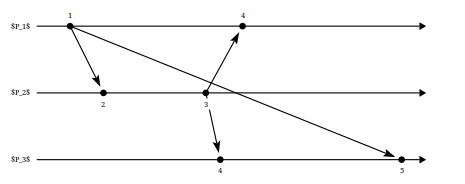

In [77]:
messagePassingExampleScalar3 :: Diagram B
messagePassingExampleScalar3 = pad 1.1 $
     mkWorlds [ ("$P_1$", 70, [], [ m1send, m2recv1])
              , ("$P_2$", 10, [], [ m1recv2, m2send])
              , ("$P_3$", -50, [], [ m2recv3, m1recv3 ])
              ]
              [ ("m1send", "m1recv1")
              , ("m1send", "m1recv2")
              , ("m1send", "m1recv3")
              , ("m2send", "m2recv1")
              , ("m2send", "m2recv3")
              ]
              messagePassingArrowOpts
  where
    m1send  = ("m1send", "1", 30, littleup, eventCircle)
    m1recv3 = ("m1recv3", "5", 328, littledown, eventCircle)
    m1recv2 = ("m1recv2", "2", 60, littledown, eventCircle)
    m2send  = ("m2send", "3", 152, littledown, eventCircle)
    m2recv1 = ("m2recv1", "4", 185, littleup, eventCircle)
    m2recv3 = ("m2recv3", "4", 165, littledown, eventCircle)

    
diagram messagePassingExampleScalar3

# Shared Memory

In [78]:
memoryArrowOpts :: ArrowOpts Double
memoryArrowOpts = with & arrowHead  .~ dart 
       & arrowTail .~ noTail
       & headLength .~ normal
       & tailLength .~ normal
       & headGap    .~ small
       & shaftStyle %~ dashingN [0.03,0.03] 0 # lwL 1

## Client requests

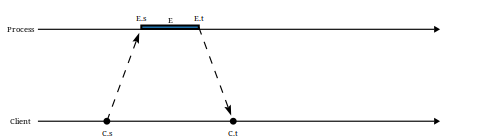

In [85]:
request = pad 1.1 $
     mkWorlds [ ("Process", 90, [("P1", "E", 90, 50)], [("", "E.s", 90, Just(0, 10), mempty), ("", "E.t", 140, Just(0, 10), mempty)])
              , ("Client", 10, [], [("S", "C.s", 60, Just(0, -10), eventCircle), ("T", "C.t", 170, Just (0, -10), eventCircle)])
              ]
              [ (toName "S", "P1" .> "start")
              , ("P1" .> "stop", toName "T")
              ]
              memoryArrowOpts
    
diagram request

## External order

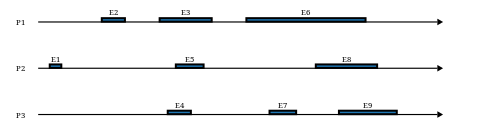

In [94]:
request = pad 1.1 $
    mkWorlds [ ("P1", 80, [p11, p12, p13], [])
             , ("P2",  40, [p21, p22, p23], [])
             , ("P3",   0,  [p31, p32, p33], [])
             ]
             ([] :: [(String,String)])
             memoryArrowOpts
  where
       p11 = ("P11", "E2", 55, 20)
       p12 = ("P12", "E3", 105, 45)
       p13 = ("P13", "E6", 180, 103)
       p21 = ("P21", "E1", 10, 10)
       p22 = ("P22", "E5", 119, 24)
       p23 = ("P23", "E8", 240, 53)
       p31 = ("P31", "E4", 112, 20)
       p32 = ("P32", "E7", 200, 23)
       p33 = ("P33", "E9", 260, 50)
       edges = [ ("P11" .> "stop", "P22" .> "start")
              , ("P12" .> "stop", "P32" .> "start")
              , ("P21" .> "stop", "P31" .> "start")
              , ("P22" .> "stop", "P13" .> "start")
              , ("P22" .> "stop", "P32" .> "start")
              , ("P21" .> "stop", "P11" .> "start")
              , ("P32" .> "stop", "P23" .> "start")
              , ("P31" .> "stop", "P13" .> "start")
              ]

diagram request

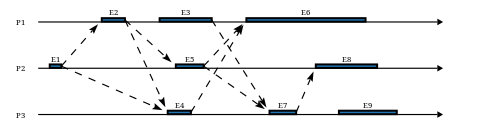

In [96]:
request = pad 1.1 $
    mkWorlds  [ ("P1", 80, [p11, p12, p13], [])
              , ("P2",  40, [p21, p22, p23], [])
              , ("P3",   0,  [p31, p32, p33], [])
              ]
              edges
              memoryArrowOpts
  where
       p11 = ("P11", "E2", 55, 20)
       p12 = ("P12", "E3", 105, 45)
       p13 = ("P13", "E6", 180, 103)
       p21 = ("P21", "E1", 10, 10)
       p22 = ("P22", "E5", 119, 24)
       p23 = ("P23", "E8", 240, 53)
       p31 = ("P31", "E4", 112, 20)
       p32 = ("P32", "E7", 200, 23)
       p33 = ("P33", "E9", 260, 50)
       edges = [ ("P11" .> "stop", "P22" .> "start")
              , ("P11" .> "stop", "P31" .> "start")
              , ("P12" .> "stop", "P32" .> "start")
              , ("P21" .> "stop", "P31" .> "start")
              , ("P22" .> "stop", "P13" .> "start")
              , ("P22" .> "stop", "P32" .> "start")
              , ("P21" .> "stop", "P11" .> "start")
              , ("P32" .> "stop", "P23" .> "start")
              , ("P31" .> "stop", "P13" .> "start")
              ]

diagram request

## Directed Acyclic Graphs

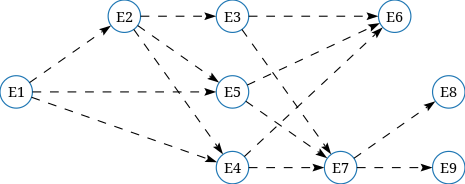

In [ ]:
dagArrowOpts :: ArrowOpts Double
dagArrowOpts = with & arrowHead  .~ dart 
       & arrowTail .~ noTail
       & headLength .~ normal
       & tailLength .~ normal
       & headGap    .~ none
       & tailGap    .~ none
       & shaftStyle %~ dashingN [0.03,0.03] 0 # lwL 0.1
       
mkNode :: String -> Double -> Double -> Diagram B
mkNode name x y = (circle 1.5 <> text name) # lc myBlue # named name # translate (r2 (x, y))

partialOrder =
  (mkNode "E1" 0 0 <>
  mkNode "E2" 10 7 <>
  mkNode "E3" 20 7 <>
  mkNode "E5" 20 0 <>
  mkNode "E4" 20 (-7) <>
  mkNode "E6" 35 7 <>
  mkNode "E7" 30 (-7) <>
  mkNode "E8" 40 0 <>
  mkNode "E9" 40 (-7))
  # attachAllOutside' dagArrowOpts
  [ (toName "E1", toName "E2")
  , (toName "E2", toName "E3")
  , (toName "E2", toName "E4")
  , (toName "E2", toName "E5")
  , (toName "E1", toName "E5")
  , (toName "E1", toName "E4")
  , (toName "E3", toName "E6")
  , (toName "E5", toName "E6")
  , (toName "E4", toName "E6")
  , (toName "E3", toName "E7")
  , (toName "E5", toName "E7")
  , (toName "E4", toName "E7")
  , (toName "E7", toName "E8")
  , (toName "E7", toName "E9")
  ]

diagram partialOrder

Any of the following are okay orderings

$$ E1 \to E2 \to E3 \to E4 \to E5 \to E6 \to E7 \to E8 $$

$$ E1 \to E4 \to E2 \to E5 \to E3 \to E7 \to E8 \to E6 $$

$$ E1 \to E2 \to E5 \to E4 \to E3 \to E7 \to E6 \to E8 $$

The following are not permissible prefixes of a linearized history.


$$ E1 \to E3 \to E2 \to \ldots $$

Violates program order

$$ E1 \to E5 \to E2 \to \ldots $$

In [124]:
mkArrow :: ArrowOpts Double -> Bool -> Point V2 Double -> Point V2 Double ->  Diagram B
mkArrow opts dashed = arrowBetween' opts # lw 2
 
attach :: ArrowOpts Double -> Bool -> (Name, Name) -> Diagram B -> Diagram B
attach opts dashed (n1, n2) = 
  withName n1 $ \b1 ->
  withName n2 $ \b2 ->
       atop (mkArrow opts dashed (location b1) (location b2))
       
attachAll :: ArrowOpts Double -> Bool -> [(Name, Name)] -> Diagram B -> Diagram B
attachAll opts dashed = appEndo . foldMap (Endo . attach opts dashed)

opts = def & arrowHead  .~ dart 
       & arrowTail .~ noTail
       & headLength .~ normal
       & tailLength .~ normal
       & tailGap    .~ 20
       & headGap    .~ 20
       
mkNode :: String -> Double -> Double -> Diagram B
mkNode name x y = (circle 1.5 <> text name) # named name # translate (r2 (x, y))

diagram $ (mkNode "E1" 0 0 <> mkNode "E2" 10 7 <> mkNode "E3" 20 7 <> mkNode "E5" 20 0 <> mkNode "E4" 20 (-7) <> mkNode "E6" 30 7 <> mkNode "E7" 30 (-7) <> mkNode "E8" 40 (0)) 
  # attachAll opts True [(toName "E1", toName "E2"), (toName "E2", toName "E3"), (toName "E1", toName "E5"), (toName "E1", toName "E4"), (toName "E3", toName "E6"), (toName "E5", toName "E6")
  , (toName "E4", toName "E6"), (toName "E3", toName "E7"), (toName "E5", toName "E7"), (toName "E4", toName "E7"), (toName "E7", toName "E8")
  ]

: 

## Linear consistency

In [125]:
linear1 = pad 1.1 $
     mkWorlds [ ("P2", 40, [("P21", "W(y, 1)", 40, 63), ("P23", "R(x,2)", 200, 33)], [])
              , ("P1", 0,  [("P11", "W(x, 2)", 10, 52), ("P12", "R(y,1)", 140, 83)], [])
              ]
              [
              ] opts False
linearTemplate = pad 1.1 $
     mkWorlds [ ("P2", 40, [("P21", "W(x, 1)", 40, 63), ("P23", "R(x,_)", 200, 33)], [])
              , ("P1", 0,  [("P11", "W(x, 2)", 10, 52), ("P12", "R(x,_)", 140, 83)], [])
              ]
              [
              ]
              opts False
linear2 = pad 1.1 $
     mkWorlds [ ("P2", 40, [("P21", "W(x, 1)", 40, 63), ("P23", "R(x,2)", 200, 33)], [(45, "", "", mkLinearization), (215, "", "", mkLinearization)])
              , ("P1", 0,  [("P11", "W(x, 2)", 10, 52), ("P12", "R(x,2)", 140, 83)], [(57, "", "", mkLinearization), (180, "", "", mkLinearization)])
              ]
              [
              ]
              opts False
linear3 = pad 1.1 $
     mkWorlds [ ("P2", 40, [("P21", "W(x, 1)", 40, 63), ("P23", "R(x,1)", 200, 33)], [(90, "", "", mkLinearization), (215, "", "", mkLinearization)])
              , ("P1", 0,  [("P11", "W(x, 2)", 10, 52), ("P12", "R(x,1)", 140, 83)], [(25, "", "", mkLinearization), (180, "", "", mkLinearization)])
              ]
              [
              ]
              opts False
nonlinear0 = pad 1.1 $
     mkWorlds [ ("P2", 40, [("P21", "W(y, 1)", 40, 63), ("P23", "R(x,2)", 200, 33)], [])
              , ("P1", 0,  [("P11", "W(x, 2)", 10, 52), ("P12", "R(y,0)", 140, 83)], [])
              ]
              [
              ]
              opts False
nonlinear1 = pad 1.1 $
     mkWorlds [ ("P2", 40, [("P21", "W(x, 1)", 40, 63), ("P23", "R(x,1)", 200, 33)], [])
              , ("P1", 0,  [("P11", "W(x, 2)", 10, 52), ("P12", "R(x,2)", 140, 83)], [])
              ]
              [
              ]
              opts False
nonlinear2 = pad 1.1 $
     mkWorlds [ ("P2", 40, [("P21", "W(x, 1)", 40, 63), ("P23", "R(x,2)", 200, 33)], [])
              , ("P1", 0,  [("P11", "W(x, 2)", 10, 52), ("P12", "R(x,1)", 140, 83)], [])
              ]
              [
              ]
              opts False

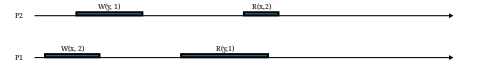

In [126]:
linear1

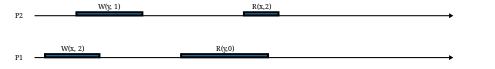

In [127]:
nonlinear0

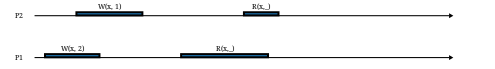

In [128]:
linearTemplate

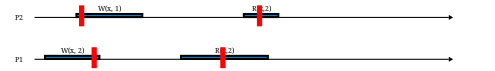

In [129]:
linear2

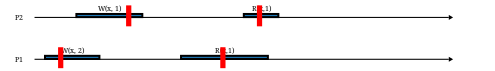

In [130]:
linear3

On the other hand, the following history is not linearizable, as the read requests evidently disagree about whether the $W(x,1)$ or $W(x,2)$ event occurred first.

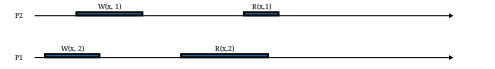

In [131]:
nonlinear1 -- but sequential

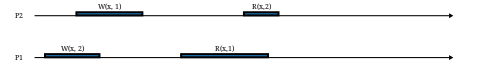

In [132]:
nonlinear2 -- and not sequential

## CAP Theorem

## Sequential Consistency

### Sequential but not linearizable

In [ ]:
sequential1 = nonlinear1
              
sequential2 = pad 1.1 $
     mkWorlds [ ("P2", 40, [("P21", "W(x, 1)", 140, 43), ("P23", "R(x,1)", 200, 33)], [])
              , ("P1", 0,  [("P11", "W(x, 2)", 10, 52), ("P12", "R(x,2)", 65, 63)], [])
              ]
              [
              ]
              opts False
              
sequential3 = pad 1.1 $
     mkWorlds [ ("P", 40, [("P11", "W(x, 2)", 10, 52), ("P12", "R(x,2)", 65, 63), ("P21", "W(x, 1)", 140, 43), ("P23", "R(x,1)", 200, 33)], [])
              ]
              [
              ]
              opts False

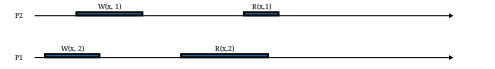

In [ ]:
sequential1

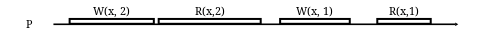

In [19]:
sequential3

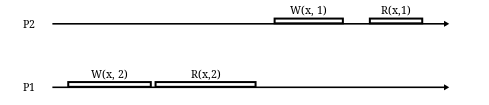

In [20]:
sequential2

### Unavailability

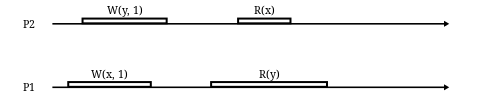

In [ ]:
sequential4 = pad 1.1 $
     mkWorlds [ ("P2", 40, [("P21", "W(y, 1)", 19, 53), ("P23", "R(x)", 117, 33)], [])
              , ("P1", 0,  [("P11", "W(x, 1)", 10, 52), ("P12", "R(y)", 100, 73)], [])
              ]
              [
              ]
              opts False
sequential4

### Non-sequentially consistent

### Sequential consistency is not composable

Here we see a history that is not sequentially consistent.

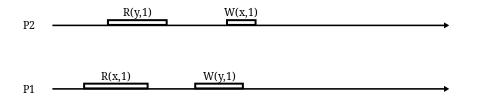

In [29]:
worldlines1 = pad 1.1 $
     mkWorlds [ ("P2", 50, [("P21", "R(y,1)", 35, 37), ("P22", "W(x,1)", 110, 18)], [])
              , ("P1", 10, [("P11", "R(x,1)", 20, 40), ("P12", "W(y,1)", 90, 30)], [])
              ]
              [ (toName "S", "P1" .> "start")
              , ("P1" .> "stop", toName "T")
              ]
              (with & arrowHead  .~ dart 
                & arrowTail .~ noTail
                & headLength .~ normal
                & tailLength .~ normal
                & headGap    .~ small) False
    
diagram worldlines1

On the other hand, $H|x$ and $H|y$ are both sequentially consistent. Therefore, to enforce sequential consistency, it does not suffice to enforce sequential consistency for each data item independently. One often says sequential consistency is not *composible*.

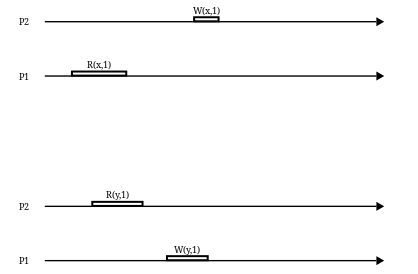

In [30]:
hx = pad 1.1 $
     mkWorlds [ ("P2", 50, [("P22", "W(x,1)", 110, 18)], [])
              , ("P1", 10, [("P11", "R(x,1)", 20, 40)], [])
              ]
              [ (toName "S", "P1" .> "start")
              , ("P1" .> "stop", toName "T")
              ] def False
hy = pad 1.1 $
     mkWorlds [ ("P2", 50, [("P21", "R(y,1)", 35, 37)], [])
              , ("P1", 10, [("P12", "W(y,1)", 90, 30)], [])
              ]
              [ (toName "S", "P1" .> "start")
              , ("P1" .> "stop", toName "T")
              ] def False
diagram (vsep 70 [hx, hy])

## Causal consistency

### Causally consistency but not sequentially consistent

### Causally inconsistent

## Topological models of network connectivity

In [31]:
n = 8

-- A routine for generating a random set of vectors
randomVectors = do
  g1 <- newStdGen
  g2 <- newStdGen
  let as = take n (randomRs (-1/15,1/15) g1) :: [Double]
  let rs = take n (randomRs (5, 22) g2)  :: [Double]
  print $ zipWith3 (\i a r -> r *^ angleV (1/8 * i + a @@ turn)) [0,1..] as rs
  
randomVectors

[V2 18.132230341751445 1.8606358444411395,V2 10.003108353491168 9.626374430046004,V2 1.8519766101321047 8.780420450962385,V2 (-10.072943482697806) 9.233521392773378,V2 (-18.51214262624723) (-3.747848707297802),V2 (-7.7067266918489805) (-9.470423849196232),V2 (-5.654930144861511) (-18.857700175084958),V2 17.18262503344625 (-8.277396626946087)]

In [32]:
locs = [V2 21.4063406410043 (-1.1272911227127032),V2 24.37969880304756 10.057406303193646,V2 (-0.4726752351978615) 11.573848088897233,V2 (-10.59482468753915) 22.237593392371743,V2 (-9.556087413178094) 1.8164512857365724,V2 (-25.044888924086163) (-9.943164197495586),V2 (-8.03073387780946) (-24.58180088811591),V2 11.235468276950694 (-14.494605634108355)]

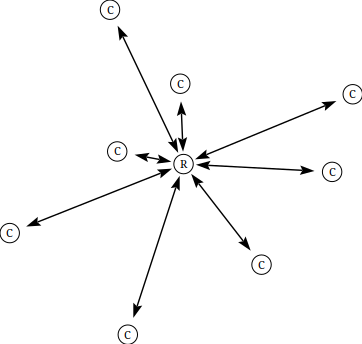

In [33]:
mkArrow = arrowBetween' (with & arrowHead  .~ dart  & arrowTail .~ dart'
                                  & headLength .~ normal & tailLength .~ normal
                                  & tailGap    .~ large
                                  & headGap    .~ normal)
node :: String -> V2 Double -> Diagram B
node lbl vec = translate vec $
  text lbl # fontSizeL 1.2 # fc black <>
  circle 1.4 # fc white # lw 1 # lc black
  
nodes = map (\l -> node "C" l # named "p" <> mkArrow (origin .+^ l) (0 ^& 0)) locs

diagram $ node "R" (0 ^& 0) <> mconcat nodes